# Problem Description
LendingClub (LC) is a peer-to-peer lending platform that pairs individual investors (those that lend money) with borrowers. The objective of this project is to develop a supervised learning algorithm to improve LC's profitability by predicting whether a potential borrower should be approved for a loan based on the borrower’s attributes.

LC's revenue is dependent upon having enough lenders to provide capital to loan out to borrowers. LC generates revenue in two primary ways. Firstly, borrowers are required to pay a one-time origination fee of 1.11% to 5% of the total loan amount. Secondly, every time a borrower makes an interest payment to their lender, LC charges lenders a 1% fee. If a borrower defaults on their loan, LC does not provide any reimbursement. Thus, it is imperative that LC keeps the lenders on its platform satisfied by ensuring that borrowers who are likely to default on their loans in the future are declined from using the LC service. This can be achieved by creating an algorithm that will minimize the number of false positves (instances that are predicted to not default however end up defaulting in the future). Based on LC's 2018 annual report, each defaulted loan results in a $1300 loss of customer lifetime value.

The underlying data set used to train and test the models was a list of customers who had applied and been approved for a loan from LendingClub between 2007-2011. As a result, algorithm developed in this project is designed to be a supplementary classifier that will further vet applicants who have already been accepted by LC's pre-existing algorithm. This is because LC's current loan approval process resulted in a data set in which approximately 14% of instances were false positives. Thus, this has caused a significant loss of customer lifetime value and there is much room for improvement.  

# Data Preparation
The following steps were undertaken to prepare the data: 

1. The original data set initially contained some instances where the corresponding customer was approved for a loan based on an older LendingClub creditworthiness determination process. These data points were excluded as they would not be reflective of LC's current approval process. 


2. Missing numerical and categorical values for an instance were filled in with the population mean and most frequent categorical value respectively


3. One-hot encoding was implemented to transform categorical string variables to Boolean values for processing 


In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import numpy as np
from sklearn.cluster import KMeans




Data has missing values:
loan_amnt                 0
term                      0
emp_length             1078
home_ownership            0
annual_inc                0
verification_status       0
zip_code                  0
addr_state                0
delinq_2yrs               0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               50
total_acc                 0
loan_status               0
dtype: int64


In [14]:
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin

data = pd.read_csv("LoanStats3a.csv")

print("Data has missing values:\n" + str(data.isnull().sum()))

#replacing missing values
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
dataFrame = pd.DataFrame(data)
cleanData = DataFrameImputer().fit_transform(dataFrame)

print("Data after cleaning:")
print(cleanData.isnull().sum())


#use one-hot encoding to  transform categorical features to vectors of 0s and 1s. The length of these vectors is equal to the
#the number of categories that the model is expected to classify for each feature 
data_dummies = pd.get_dummies(cleanData)

#get all the rows from the data set and features of age to native-country --> all independent variables 
features = data_dummies.loc[:, "loan_amnt":"revol_util_99.90%"]

print (list(data_dummies.columns))

#get the values of the features 
X = features.values

#get the dependent variable --> variable we are trying to predict 
y = data_dummies["loan_status_Fully Paid"].values 





Data after cleaning:
loan_amnt              0
term                   0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
zip_code               0
addr_state             0
delinq_2yrs            0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
loan_status            0
dtype: int64
['loan_amnt', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'term_36 months', 'term_60 months', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_

# Feature Engineering
Implemented K-means clustering with a k value of two which added one extra binary feature to the data set representing membership within a resulting cluster.

In [18]:
#Models with KMeans clusters used as a feature 
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import numpy as np
from sklearn.cluster import KMeans

clf = KMeans(n_clusters = 2)
clf.fit(X)

labels = clf.labels_

cleanData2 = cleanData

#add KMeans as a feature vector
cleanData2["kmeans_cluster"] = labels

#use one-hot encoding to  transform categorical features to vectors of 0s and 1s. The length of these vectors is equal to the
#the number of categories that the model is expected to classify for each feature 
data_dummies2 = pd.get_dummies(cleanData2)

#get all the rows from the data set and features of age to native-country --> all independent variables 
features2 = data_dummies2.loc[:, "loan_amnt":"revol_util_99.90%"]

print (list(data_dummies2.columns))

# #get the values of the features 
X2 = features2.values

# #get the dependent variable --> variable we are trying to predict 
y2 = data_dummies2["loan_status_Fully Paid"].values 


# with KMeans clusters used as a feature 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 0, test_size = 0.2)

['loan_amnt', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'kmeans_cluster', 'term_36 months', 'term_60 months', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'zip_code_007xx', 'zip_code_010xx', 'zip_code_011xx', 'zip_code_012xx', 'zip_code_013xx', 'zip_code_014xx', 'zip_code_015xx', 'zip_code_016xx', 'zip_code_017xx', 'zip_code_018xx', 'zip_code_019xx', 'zip_code_020xx', 'zip_code_021xx', 'zip_code_022xx', 'zip_code_023xx', 'zip_code_024xx', 'zip_code_025xx', 'zip_code_026xx', 'zip_code_027xx', 'zip_code_028xx', 'zip_c

In [21]:
# select.fit(X2, y2)
# X_selected = select.transform(X2)
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


# usedFeatures = select.get_support(indices=True)

# features_df_new = features_df[usedFeatures]

# print(features_df_new)

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

mask = select.get_support()
new_features = features2.columns[mask]

print(new_features)
print(len(new_features))
print (len(list(data_dummies2.columns)))

Index(['loan_amnt', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'term_36 months', 'term_60 months',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'zip_code_010xx', 'zip_code_018xx', 'zip_code_021xx', 'zip_code_023xx',
       'zip_code_027xx', 'zip_code_028xx', 'zip_code_060xx', 'zip_code_064xx',
       'zip_code_065xx', 'zip_code_070xx', 'zip_code_072xx', 'zip_code_076xx',
       'zip_code_077xx', 'zip_code_080xx', 'zip_code_082xx', 'zip_code_087xx',
       'zip_code_088xx', 'zip

# Feature Selection
Implemented recursive feature elimination (RFE). RFE works by first calculating the accuracy of the an external estimator given the inclusion of all possible feature vectors. It then assigns a weight to each feature regarding its contribution to the model’s accuracy. The model then recursively eliminates the feature with the lowest absolute weight, and repeats this process until the model’s accuracy begins to decline as a result of features’ exclusion. The external estimator used below is the Random Forest Classifer as it is highly accurate because 400 to 1200 decision trees are created, each built from a random selection of features. Thus, it is less prone to overfitting as all trees are uncorrelated.

RFE is  more complex and accurate compared to other feature selection alternatives such as univariate statistics as no arbitrary threshold of feature significance has to be defined. Instead, the algorithm automatically takes the feature whose contribution to the model’s accuracy is the lowest and continues to remove features until it is not longer beneficial to do so. The automated nature of the process leads to improvements in the consistency and accuracy of the model. Ultimately, the remaining features are those that have been “selected” and are predictive of our target variable.

In [20]:
#Implements recursive feature elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

m = RFECV(RandomForestClassifier(), scoring='accuracy')
m.fit(X2, y2)
X_selected = m.transform(X2)

m.fit(X_train2, y_train2)
X_train_selected2 = m.transform(X_train2)
X_test_selected2 = m.transform(X_test2)

# Initial Modelling
Five models were initally tested:

1. Decision Tree Classifer
2. Naive Bayes
3. Linear Discriminant Analysis 
4. Logistic Regression
5. K-Nearest Neighbors 

It was hypothesized that both the decision tree classifier would produced the most accurate predictions for three main reasons. Firstly, decision trees are more flexible than linear models given its ability to represent substantially larger nonlinear relationships between feature and target variables. Secondly, this flexibility aids in the analysis of larger training sets such as the data set provided (42,500 instances). Finally, decision tree models are robust to missing and irrelevant values in the data. 




In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics

kNeighbor = KNeighborsClassifier()
kNeighbor.fit(X_train_selected2, y_train2)

dTree = DecisionTreeClassifier(max_depth=8, random_state = 0)
dTree.fit(X_train_selected2, y_train2)

LDA = LinearDiscriminantAnalysis() 
LDA.fit(X_train_selected2, y_train2)

logReg = LogisticRegression(random_state = 0)
logReg.fit(X_train_selected2, y_train2)

naiveB = GaussianNB()
naiveB.fit(X_train_selected2, y_train2)

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

# Hyperparemeter Tuning 

In [38]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

#Setup the paremeters and distributions to sample from: param_dist
#max depth from 3 to infinity 
param_dist = {"max_depth":[3, None], 
             "min_samples_leaf" : randint(1,9),
             "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(dTree, param_dist, cv=5)

tree_cv.fit(X_train_selected2, y_train2)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8}


In [9]:
#svm takes too long ot process -> basic SMO algorithm is O(n^3), 
#so in case of 30 000 datapoints it has to run number of operations proportional to 
#the2 700 000 000 000 which takes too long to compute.

# Model Evaluation
## Cross Validation

In [10]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(kNeighbor, X_selected, y2, cv = 10, scoring = "accuracy").mean())

print(cross_val_score(dTree, X_selected, y2, cv = 10, scoring = "accuracy").mean())

print(cross_val_score(LDA, X_selected, y2, cv = 10, scoring = "accuracy").mean())

print(cross_val_score(logReg, X_selected, y2, cv = 10, scoring = "accuracy").mean())

print(cross_val_score(naiveB, X_selected, y2, cv = 10, scoring = "accuracy").mean())

print(cross_val_score(aSVM, X_selected, y2, cv = 10, scoring = "accuracy").mean())



## ROC Curves

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def roc_plot(actual, probability, model_name):
    """
    Inputs: 
    - actual values of y_test (1 dimensional array)
    - probability estimate of y_test (1 dimensional array)
    - name of the classifier (string)
    
    Output: ROC plot with AUC
    """
    fpr, tpr, _ = roc_curve(actual, probability)
    plt.title(model_name+' Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.xlabel('False Positive Rate')
    return plt.show()

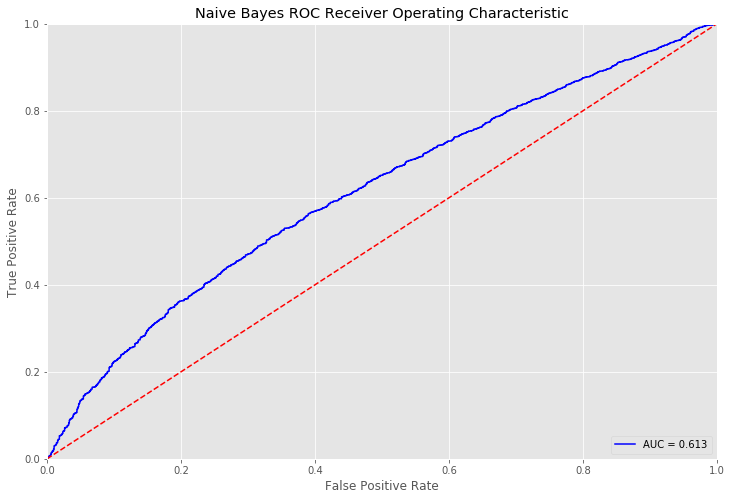

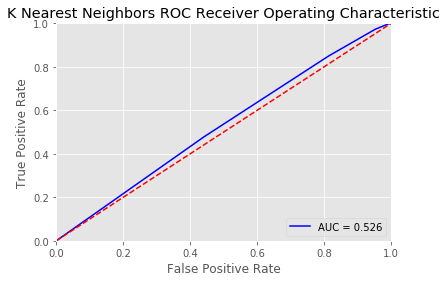

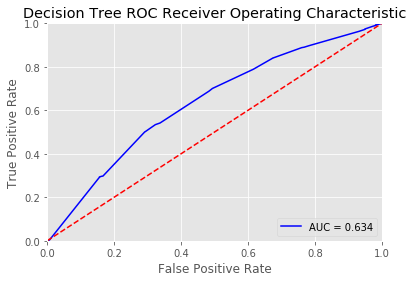

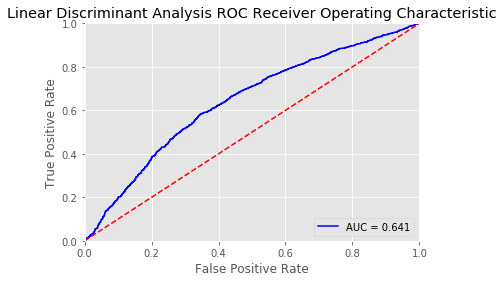

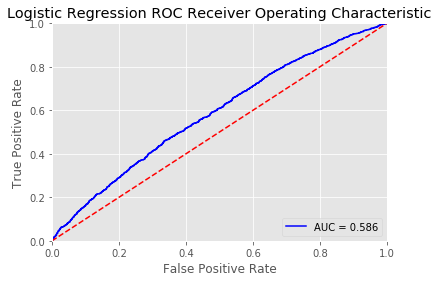

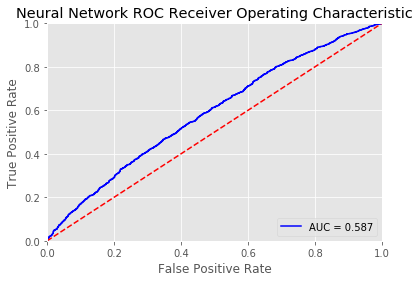

In [40]:
naiveBRaw = naiveB.predict_proba(X_test_selected2)
naiveBProb = naiveBRaw[:,1]

kNeighProbRaw = kNeighbor.predict_proba(X_test_selected2)
kNeighProb = kNeighProbRaw[:,1]

dtProbRaw = dTree.predict_proba(X_test_selected2)
dtProb = dtProbRaw[:,1]

LdaProbRaw = LDA.predict_proba(X_test_selected2)
LdaProb = LdaProbRaw[:,1]

logRegRaw = logReg.predict_proba(X_test_selected2)
logRegProb = logRegRaw[:,1]

neuralRaw = neural.predict_proba(X_test_selected2)
neuralProb = neuralRaw[:,1]

roc_plot(y_test2, naiveBProb, "Naive Bayes ROC")
roc_plot(y_test2, kNeighProb, "K Nearest Neighbors ROC")
roc_plot(y_test2, dtProb, "Decision Tree ROC")
roc_plot(y_test2, LdaProb, "Linear Discriminant Analysis ROC")
roc_plot(y_test2, logRegProb, "Logistic Regression ROC")
roc_plot(y_test2, neuralProb, "Neural Network ROC")


# Profit Curves
Decision Tree Classifier generated highest profits

In [25]:
def profit_curve(actual, probability):
    """
    Inputs: 
    - actual values of y_test (1 dimensional array)
    - probability estimate of y_test (1 dimensional array)
    
    Outputs: 
    - cumulative percentage of customers targeted (1 dimensional array)
    - cumulative profit from targeting (1 dimensional array)
    - optimal percentage of targeted customers to maximize profits (number)
    - maximum profit acheivable (number)
    
    Example Call:
    >>> cum_percent, cum_profit, optimal_targeting, max_profit = profit_curve(actual, probability)
    """
    
    TP = 399.5
    FP = -1300

    df = pd.DataFrame([actual,probability], index=['a','p']).T.sort_values('p',ascending=False)
    df['profit'] = np.where(df['a'] == 1, TP, FP)
    df['cum_profit'] = df['profit'].cumsum()
    df['counter'] = 1
    df['cum_percent'] = df['counter'].cumsum() / len(df['counter'])

    max_index = np.argmax(df['cum_profit'])
    max_profit = df['cum_profit'][max_index]
    optimal_targeting = df['cum_percent'][max_index]
    
    return df['cum_percent'], df['cum_profit'], optimal_targeting, max_profit

C:\Users\MyPC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
C:\Users\MyPC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
C:\Users\MyPC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior

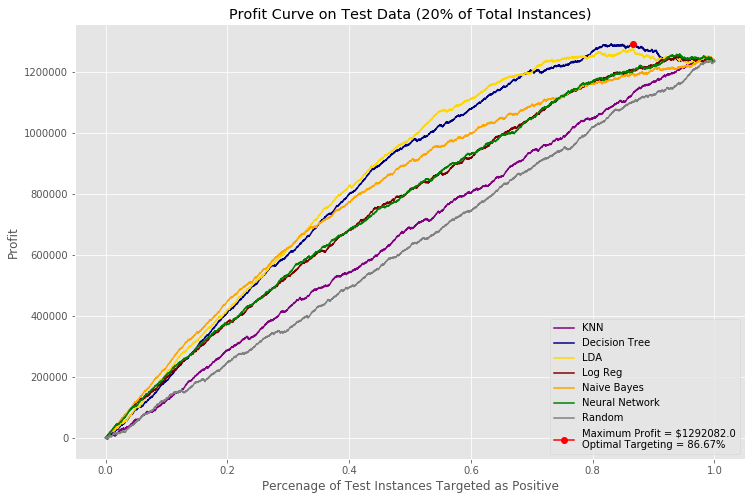

Maximum Profit on Test Data: $1292082.0
Optimal Targeting: 0.8666750439808997
Estimated Maximum Profit on Entire Data Set: $6460410.0


In [29]:
#creates random probabilities for the random selection profit curve
randomSelectProb = np.random.rand(1,len(y_test2))
                                  
randomSelectionData = profit_curve(y_test2, randomSelectProb)

cumPercentNB, cumProfitNB, optTargetNB, maxProfitNB = profit_curve(y_test2, naiveBProb) 
cumPercentKNN, cumProfitKNN, optTargetKNN, maxProfitKNN = profit_curve(y_test2,kNeighProb) 
cumPercentDT, cumProfitDT, optTargetDT, maxProfitDT  = profit_curve(y_test2, dtProb) 
cumPercentLDA, cumProfitLDA, optTargetLDA, maxProfitLDA = profit_curve(y_test2, LdaProb)
cumPercentLR, cumProfitLR, optTargetLR, maxProfitLR  = profit_curve(y_test2, logRegProb)
cumPercentNeural, cumProfitNeural, optTargetNeural, maxProfitNeural  = profit_curve(y_test2, neuralProb)
cumPercentRand, cumProfitRand, optTargetRand, maxProfitRand  = profit_curve(y_test2, randomSelectProb)



plt.plot(cumPercentKNN, cumProfitKNN, label = "KNN", color = "purple")
plt.plot(cumPercentDT, cumProfitDT, label = "Decision Tree", color = "navy")
plt.plot(cumPercentLDA, cumProfitLDA, label = "LDA", color = "gold")
plt.plot(cumPercentLR, cumProfitLR, label = "Log Reg", color = "maroon")
plt.plot(cumPercentNB, cumProfitNB, label = "Naive Bayes", color = "orange")
plt.plot(cumPercentNeural, cumProfitNeural, label = "Neural Network", color = "green")
plt.plot(cumPercentRand, cumProfitRand, label = "Random", color = "grey")


plt.plot(optTargetDT, maxProfitDT, label=f"Maximum Profit = ${maxProfitDT}\nOptimal Targeting = {optTargetDT:.2%}", marker='o', color = "red")

plt.title('Profit Curve on Test Data (20% of Total Instances)')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.xlabel("Percenage of Test Instances Targeted as Positive")
plt.ylabel("Profit")
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()


print("Maximum Profit on Test Data: $" + str(maxProfitDT))
print("Optimal Targeting:", optTargetDT)


print("Estimated Maximum Profit on Entire Data Set: $" + str(maxProfitDT*5))

# Bagging Classifier
Since decision tree had the highest profits, used it as the base estimator for the bagging classifier

Bagging: Building multiple models (typically of the same type) from different subsamples of the training dataset. (In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced. Examples: Bagging methods, Forests of randomized trees, ...)

Bagging is suitable for models that tend to overfit (high variance, low bias models)


In [39]:
from sklearn.ensemble import BaggingClassifier

bg = BaggingClassifier(tree_cv, max_samples = 0.5, max_features = 1.0, n_estimators =20 )
bg.fit(X_train_selected2, y_train2)
print("\nBagging Classifier")
print ( "Accuracy on training = %.4f" % metrics.accuracy_score(bg.predict(X_train_selected2), y_train2) )
print ( "Accuracy on test = %.4f" % metrics.accuracy_score(bg.predict(X_test_selected2), y_test2) )


Bagging Classifier
Accuracy on training = 0.8578
Accuracy on test = 0.8562


# Profit Curve of Bagging Classifier
Bagging classifier generated higher profits than the decision tree model

C:\Users\MyPC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
C:\Users\MyPC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
C:\Users\MyPC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior

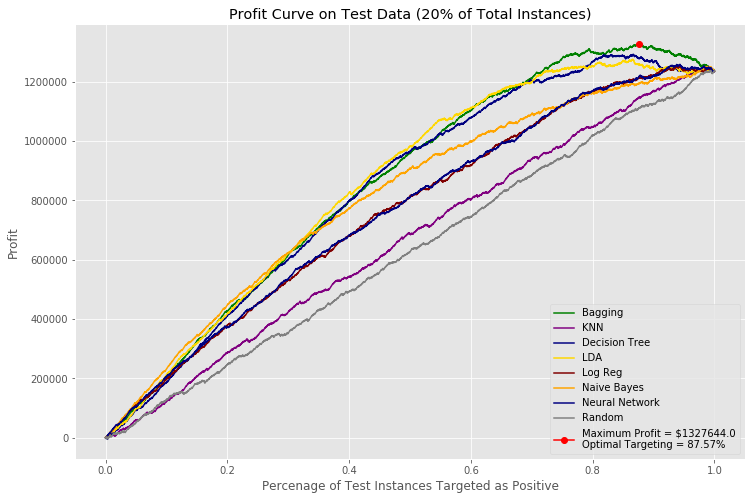

Maximum Profit on Test Data: $1327644.0
Optimal Targeting: 0.8757225433526011
Estimated Maximum Profit on Entire Data Set: $6638220.0


In [45]:
bgRaw = bg.predict_proba(X_test_selected2)
bgProb = bgRaw[:,1]

#creates random probabilities for the random selection profit curve
randomSelectProb = np.random.rand(1,len(y_test2))
                                  
randomSelectionData = profit_curve(y_test2, randomSelectProb)


#cumPercent, cumProfit, optTarget, maxProfit

bgInfo = profit_curve(y_test2, bgProb) 
nbInfo = profit_curve(y_test2, naiveBProb) 
knnInfo = profit_curve(y_test2,kNeighProb) 
dtInfo = profit_curve(y_test2, dtProb) 
ldaInfo= profit_curve(y_test2, LdaProb)
lrInfo  = profit_curve(y_test2, logRegProb)
cumPercentNeural, cumProfitNeural, optTargetNeural, maxProfitNeural  = profit_curve(y_test2, neuralProb)

randInfo  = profit_curve(y_test2, randomSelectProb)

plt.plot(bgInfo[0], bgInfo[1], label = "Bagging", color = "green")
plt.plot(knnInfo[0], knnInfo[1], label = "KNN", color = "purple")
plt.plot(dtInfo[0], dtInfo[1], label = "Decision Tree", color = "navy")
plt.plot(ldaInfo[0], ldaInfo[1], label = "LDA", color = "gold")
plt.plot(lrInfo[0], lrInfo[1], label = "Log Reg", color = "maroon")
plt.plot(nbInfo[0], nbInfo[1], label = "Naive Bayes", color = "orange")
plt.plot(cumPercentNeural, cumProfitNeural, label = "Neural Network", color = "navy")
plt.plot(randInfo[0], randInfo[1], label = "Random", color = "grey")


maxProfit = max(bgInfo[3],knnInfo[3], dtInfo[3], ldaInfo[3], lrInfo[3], randInfo[3], nbInfo[3])

plt.plot(bgInfo[2], maxProfit, label=f"Maximum Profit = ${maxProfit}\nOptimal Targeting = {bgInfo[2]:.2%}", marker='o', color = "red")

plt.title('Profit Curve on Test Data (20% of Total Instances)')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.xlabel("Percenage of Test Instances Targeted as Positive")
plt.ylabel("Profit")
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

print("Maximum Profit on Test Data: $" + str(maxProfit))
print("Optimal Targeting:", bgInfo[2])


print("Estimated Maximum Profit on Entire Data Set: $" + str(maxProfit*5))